# Structural similarity

In previous two exercises, we have characterized chemical structures using binary vectors representing their features: either directly (structural keys such as MACCS) or in a hashed form (hashed fingerprints such as ECFP). Aside from narrowing down substructure searches or searching for specific fragments, these binary feature vectors can be used to quantify structural similarity. This is based on the premise that structures with similar feature vectors have to be structurally similar themselves. This may sound a bit sketchy, but as you will see, it works pretty well, especially with hashed fingerprints such as ECFP.

This gets us to the question of how to measure similarity of binary vectors. Luckily, this is already a pretty generic question that has been extensively worked upon long before cheminformatics was a thing. Probably the simplest, and definitely the most often used one in cheminformatics is the [Tanimoto similarity](https://en.wikipedia.org/wiki/Jaccard_index) aka the Jaccard index. Tanimoto similarity coefficient is measure of how many features do the two compared feature vectors have in common, compared to how many features they have overall. This means that feature vectors that share all features, i.e. are completely identical, will have Tanimoto coefficient 1. Feature vectors that share no features at all have Tanimoto coefficient of 0, and any other cases will be somewhere between these two limit values. Much more info is on the wiki artice, no point in copypasting :) Other measures such as [Manhattan distance](https://en.wikipedia.org/wiki/Taxicab_geometry) or [Dice coefficient](https://en.wikipedia.org/wiki/Dice%27s_coefficient) are also often implemented in cheminformatic toolkits, ready to be used for some edge cases. Quite a few are described in the [Daylight documentation](https://www.daylight.com/dayhtml/doc/theory/theory.finger.html), Section 6.3. However, Tanimoto is pretty much the vanilla of binary vector comparisons. Let's implement it: 

In [1]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import csv

In [2]:
# let's define the Tanimoto similarity for ourselves:

def tanimoto(vector1, vector2):
    set_bits = 0
    shared_bits = 0
    for bit1, bit2 in zip(vector1, vector2):
        if bit1 or bit2: # at least one vector has this feature
            set_bits += 1
            if bit1 and bit2: # both vectors have this feature
                shared_bits += 1
    return shared_bits / set_bits

# and check our implementation on several vectors
print(tanimoto([1, 1, 0, 0], [0, 0, 1, 1])) # share nothing
print(tanimoto([0, 1, 1, 0], [1, 0, 1, 0])) # share bit of 3
print(tanimoto([1, 1, 1, 1], [0, 0, 1, 1])) # share 2 bits of 4
print(tanimoto([1, 1, 1, 1], [0, 1, 1, 1])) # share 3 bits of 4
print(tanimoto([1, 1, 0, 0], [1, 1, 0, 0])) # share 2 bits of 2

0.0
0.3333333333333333
0.5
0.75
1.0


This implementation seems ok for our little 4-bit vectors. Let's try it on some actual fingerprint vectors :)

In [3]:
# load your own set, and DrugBank :)
with open('../data/chembl_mtor_ic50.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=";")
    mtor_ligands = [Chem.MolFromSmiles(m['Smiles']) for m in reader]

suppl = Chem.SDMolSupplier('../data/drugbank.sdf')
drugs = [m for m in suppl if m]

RDKit ERROR: [14:36:45] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [14:36:45] ERROR: Could not sanitize molecule ending on line 20009
RDKit WARNING: [14:36:45] Warning: conflicting stereochemistry at atom 5 ignored.
RDKit WARNING: [14:36:45] Warning: conflicting stereochemistry at atom 5 ignored.
RDKit ERROR: [14:36:45] ERROR: Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [14:36:45] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [14:36:45] ERROR: Could not sanitize molecule ending on line 250947
RDKit ERROR: [14:36:45] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [14:36:45] Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [14:36:45] ERROR: Could not sanitize molecule ending on line 258130
RDKit ERROR: [14:36:45] ERROR: Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [14:36:45] Can't kek

RDKit ERROR: [14:36:46] ERROR: Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
RDKit ERROR: 
RDKit ERROR: [14:36:46] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [14:36:46] ERROR: Could not sanitize molecule ending on line 592639
RDKit ERROR: [14:36:46] ERROR: Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [14:36:46] Explicit valence for atom # 12 N, 4, is greater than permitted
RDKit ERROR: [14:36:46] ERROR: Could not sanitize molecule ending on line 595909
RDKit ERROR: [14:36:46] ERROR: Explicit valence for atom # 12 N, 4, is greater than permitted
RDKit ERROR: [14:36:46] Explicit valence for atom # 0 Br, 2, is greater than permitted
RDKit ERROR: [14:36:46] ERROR: Could not sanitize molecule ending on line 599041
RDKit ERROR: [14:36:46] ERROR: Explicit valence for atom # 0 Br, 2, is greater than permitted
RDKit ERROR: [14:36:46] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [14:36:46] ER

In [4]:
from rdkit.Chem import MACCSkeys
fp1 = MACCSkeys.GenMACCSKeys(drugs[123])
fp2 = MACCSkeys.GenMACCSKeys(drugs[666])
print(fp1.ToBitString())
print(fp2.ToBitString())

00000000000000000000000000000000000000000000000000000100000000000000000000000000000010000100000001000000000000000100000000010001000101010001000110100011101011110111110
00000000000000000000000000000010000000000000000001000000010000000000000000100000000001100000010100101100010011011101101000110110000010000110010011111100111111111111110


In [5]:
tanimoto(fp1, fp2)

0.25

So, our ghetto tanimoto similarity implementation work on the MACCS keys too. Luckily, we do not have to implement similarity metrics ourselves - many are [already implemented in RDKit](https://www.rdkit.org/docs/source/rdkit.DataStructs.cDataStructs.html): 

In [6]:
from rdkit import DataStructs

In [7]:
DataStructs.TanimotoSimilarity(fp1, fp2) # same result as our own implementation :)

0.25

Now that we have our Tanimoto similarity tried and tested for both artificial small vector and also on some actual fingerprints, let's calculate MACCS keys for all our ligands and all our known drugs. Then, we can try a basic similarity search:

In [8]:
mtor_ligands_maccs = [MACCSkeys.GenMACCSKeys(m) for m in mtor_ligands]
drugs_maccs = [MACCSkeys.GenMACCSKeys(m) for m in drugs]

Let's implement a basic similarity search function. We will take a single binary vector as a query, compare it all binary vectors in the provided searched set. If its the Tanimoto similarity of the query vector to any of the searched fingerprints reaches or exceed our set cutoff value (0.8 is usually where some noticeable similarity starts to happen when using standard ECFP types), the index of the found similar vector is appended to the results.

In [9]:
def similarity_search(query_fp, searched_fp_set, cutoff=0.8):
    # we have no index, so we will have to just iterate through the entire searched set
    hits = []
    for i, fp in enumerate(searched_fp_set):
        similarity = DataStructs.TanimotoSimilarity(query_fp, fp)
        if similarity >= cutoff: # similar enough for consideration
            hits.append((i, similarity))
    return sorted(hits, key=lambda x: x[1], reverse=True) # stronger hits first

This is, in a very simplified fashon, exactly what the large, often commercial chemical databases do when users perform a similarity search. Their input structure gets fingerprinted, the resulting fingerprint compared to those in the database, and molecules with similar fingerprints are returned as hits. Of course, they do extended indexing and heuristics to make the searches quicker, alongside some hit reordering and sanitation, but the core principle is the same: create query fingerprint, compare with database fingerprints using some similarity metric, return hits above threshold. Same sh.t, different toilet :)

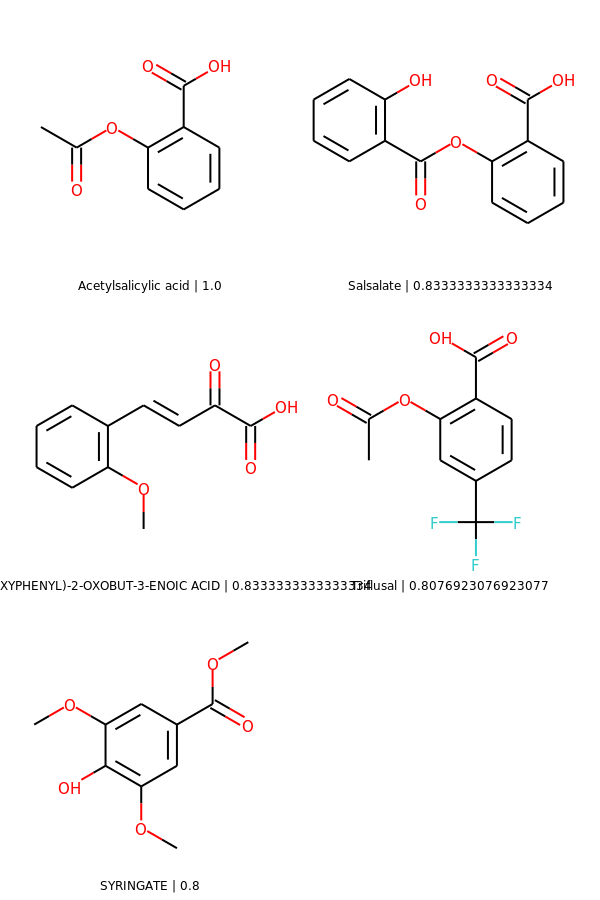

In [10]:
# let's use our similarity search method to search of aspirin in drugs.
# There should be some hits :)
aspirin = Chem.MolFromSmiles('O=C(C)Oc1ccccc1C(=O)O')
aspirin_fp = MACCSkeys.GenMACCSKeys(aspirin)
hits = similarity_search(aspirin_fp, drugs_maccs)
Draw.MolsToGridImage([drugs[hit[0]] for hit in hits],
                     molsPerRow=2, subImgSize=(300,300),
                     legends=["{} | {}".format(drugs[hit[0]].GetProp('GENERIC_NAME'), hit[1]) for hit in hits])

We found acetylsalicylic acid (i.e. Aspirin) as an exact match (tanimoto 1.0), and four other apparently quite similar structures. Seems that our similarity search is working :) let's try to look up some molecule from our ligand set within DrugBank:

In [11]:
hits = similarity_search(mtor_ligands_maccs[0], drugs_maccs)
hits

[(6687, 0.8285714285714286), (5430, 0.8088235294117647)]

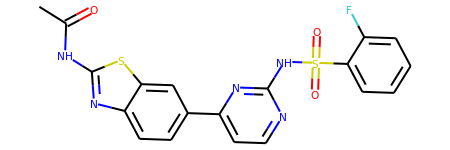

In [12]:
mtor_ligands[0]  # my query structure

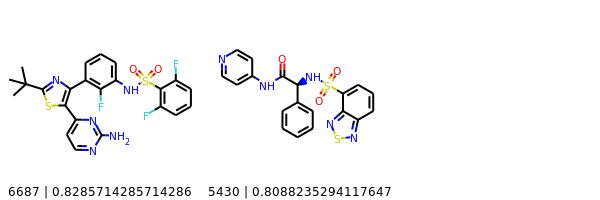

In [13]:
# the hits among Drugbank using MACCS keys
Draw.MolsToGridImage([drugs[hit[0]] for hit in hits], legends=["{} | {}".format(hit[0], hit[1]) for hit in hits])

So, our first mtor ligand hit two DrugBank structures at the lower rung of our similarity threshold, but there are already some structural patterns that are quite similar, like the S(O)(O)N-something bridge between two 6-membered cycles, the N and S-containing 5-member heterocycle, the F substitutions on the benzene cores in the stronger hit, etc. Not exact at all, but already in the ballpark, at least as far as MACCS features are concerned.

Let's do the same exact query, but using ECFP instead of MACCS:

In [14]:
mtor_ligands_ecfp = [Chem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024)
                     for m in mtor_ligands]
drugs_ecfp = [Chem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024)
              for m in drugs]

In [15]:
hits = similarity_search(mtor_ligands_ecfp[0], drugs_ecfp)
hits

[]

No similarity hits using ECFP. Let's see what the ECFP-based similarity with the two previous MACCS-based hits is:

In [16]:
DataStructs.TanimotoSimilarity(mtor_ligands_ecfp[0], drugs_ecfp[6687])

0.28735632183908044

In [17]:
DataStructs.TanimotoSimilarity(mtor_ligands_ecfp[0], drugs_ecfp[5430])

0.23809523809523808

Same query molecule, same similarity measurement, but a different feature vector type yielded very different results. The two structures hit by the similarity search based on the MACCS keys (over 0.8 Tanimoto similarity) have much lower similarity values when using ECFP. This is because MACCS and ECFP are quite different in what structural features they cover. When using fingerprint-based similarity search, it is always good idea to think a bit about what structural features do the used fingerprints represent, and therefore what is used as the basis for structural similarity. It is also a good idea to include information about the exact used feature vector type (e.g. MACCS, ECFP6-1024 bit, ECFP4-512 bit, etc.) and the exact used similarity measurement method (e.g. Tanimoto, Manhattan) whenever you present any similarity search results.

Let's search for all our ligands among the DrugBank database, to see how close we are to the known drugs:

In [18]:
mtor_ligands_queries = [(i, similarity_search(ligand_ecfp, drugs_ecfp))
                     for i, ligand_ecfp in enumerate(mtor_ligands_ecfp)]
mtor_ligands_queries

[(0, []),
 (1, []),
 (2, []),
 (3, []),
 (4, []),
 (5, []),
 (6, []),
 (7, []),
 (8, []),
 (9, []),
 (10, []),
 (11, []),
 (12, []),
 (13, []),
 (14, []),
 (15, []),
 (16, []),
 (17, [(1098, 1.0)]),
 (18, []),
 (19, []),
 (20, []),
 (21, []),
 (22, []),
 (23, [(4573, 1.0), (759, 0.8715596330275229), (1376, 0.8596491228070176)]),
 (24, []),
 (25, []),
 (26, []),
 (27, []),
 (28, []),
 (29, []),
 (30, []),
 (31, []),
 (32, []),
 (33, []),
 (34, []),
 (35, []),
 (36, [(5896, 1.0)]),
 (37, []),
 (38, []),
 (39, []),
 (40, []),
 (41, []),
 (42, []),
 (43, []),
 (44, []),
 (45, []),
 (46, []),
 (47, []),
 (48, []),
 (49, []),
 (50, []),
 (51, []),
 (52, []),
 (53, []),
 (54, []),
 (55, []),
 (56, []),
 (57, []),
 (58, []),
 (59, []),
 (60, []),
 (61, []),
 (62, []),
 (63, []),
 (64, []),
 (65, []),
 (66, []),
 (67, []),
 (68, []),
 (69, []),
 (70, []),
 (71, []),
 (72, []),
 (73, []),
 (74, []),
 (75, []),
 (76, []),
 (77, [(759, 0.8636363636363636), (1376, 0.8050847457627118)]),
 (78, []),


For every ligand, we have a list of drugs that match their structural features (ECFP4, 1024bit) at Tanimoto similarity of 0.8 and higher. Most queries come up empty at this similarity threshold of 0.8, but there are some actual hits:

In [19]:
# only take ligands that actually matched something in DrugBank
mtor_ligand_hits = [hit for hit in mtor_ligands_queries if hit[1]]
mtor_ligand_hits

[(17, [(1098, 1.0)]),
 (23, [(4573, 1.0), (759, 0.8715596330275229), (1376, 0.8596491228070176)]),
 (36, [(5896, 1.0)]),
 (77, [(759, 0.8636363636363636), (1376, 0.8050847457627118)]),
 (145, [(286, 1.0), (6675, 0.8305084745762712)]),
 (205, [(5898, 1.0)]),
 (211, [(5897, 0.9565217391304348)]),
 (218, [(5207, 1.0)]),
 (317, [(759, 1.0), (1376, 0.8878504672897196), (4573, 0.8715596330275229)]),
 (338, [(1698, 1.0)]),
 (373, [(746, 1.0)]),
 (379, [(759, 1.0), (1376, 0.8878504672897196), (4573, 0.8715596330275229)]),
 (496, [(1129, 1.0)]),
 (517, [(4573, 0.9122807017543859)]),
 (540, [(5903, 1.0)]),
 (551, [(746, 1.0)]),
 (566, [(5461, 1.0)]),
 (888, [(5897, 0.8269230769230769)]),
 (889, [(5897, 0.8113207547169812)]),
 (906, [(6136, 1.0)]),
 (954, [(6136, 1.0)]),
 (1002, [(286, 1.0), (6675, 0.8305084745762712)]),
 (1045, [(2341, 1.0)]),
 (1057, [(759, 0.8482142857142857)]),
 (1060, [(2341, 1.0)]),
 (1067, [(759, 1.0), (1376, 0.8878504672897196), (4573, 0.8715596330275229)]),
 (1095, [(114

In [20]:
len(mtor_ligands_queries), len(mtor_ligand_hits)

(4596, 56)

Here, 56 of 4596 ligands appear to be significantly structurally similar to something in DrugBank. Let's have a look at one of the ligand hits:

In [21]:
mtor_ligand_hits[1]

(23, [(4573, 1.0), (759, 0.8715596330275229), (1376, 0.8596491228070176)])

In the above, the mtor ligand 23 hits DrugBank structure 4573 fully by Tanimoto similarity over ECFP4 fingerprints, and also hits structures 759 and 1376 on a high degree of similarity. To visualize the structures: 

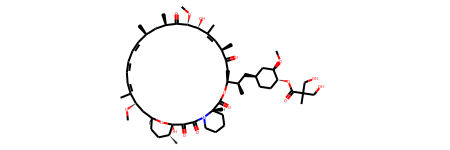

In [22]:
# The query structure
mtor_ligands[mtor_ligand_hits[1][0]]

That's one big macrocycle :) Let's see what it hits:

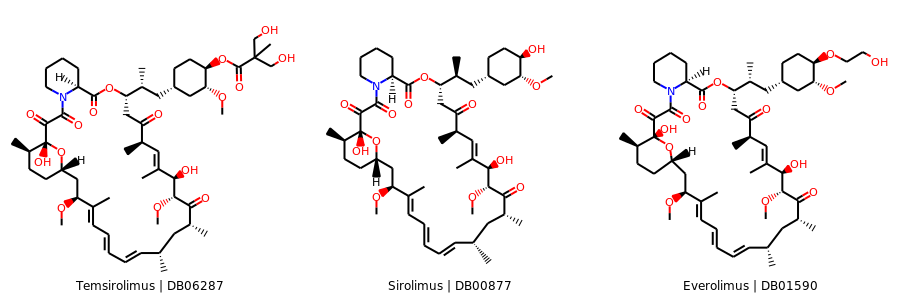

In [23]:
# And the DrugBank hits to that
hit_mols = [drugs[index] for index, similarity in mtor_ligand_hits[1][1]]
Draw.MolsToGridImage(hit_mols, molsPerRow=3, subImgSize=(300,300),
                     legends=["{} | {}".format(m.GetProp('GENERIC_NAME'), m.GetProp('DRUGBANK_ID'))
                              for m in hit_mols])

Yeah, the hits in DrugBank are also huge macrocycles, quite similar to this one actually. The full match of our mtor ligand 23 is actually Temsirolimus, a known mtor inhibitor that is an already approved drug for treatment of renal cell carcinoma. The other two hits, Sirolimus and Everolimus, are very similar in both form and function. They are part of the same mtor inhibitor drug family.

Those are the three hits from a single query structure. Let's have a look at all the DrugBank hits from all query mtor ligands:

In [24]:
drugs_hitcounts = {}
for ligand, hits in mtor_ligand_hits:
    for hit, similarity in hits:
        drugs_hitcounts[hit] = drugs_hitcounts.get(hit, 0) + 1
drugs_hitcounts

{1098: 1,
 4573: 12,
 759: 13,
 1376: 10,
 5896: 3,
 286: 2,
 6675: 2,
 5898: 2,
 5897: 6,
 5207: 2,
 1698: 2,
 746: 2,
 1129: 2,
 5903: 1,
 5461: 1,
 6136: 2,
 2341: 9,
 1140: 1,
 5853: 1,
 5114: 1,
 92: 1,
 1574: 1,
 207: 1,
 1754: 1,
 6797: 1}

In [25]:
ordered_drugs_hitcounts = sorted(drugs_hitcounts.keys(), key=lambda x: drugs_hitcounts[x], reverse=True)
ordered_drugs_hitcounts

[759,
 4573,
 1376,
 2341,
 5897,
 5896,
 286,
 6675,
 5898,
 5207,
 1698,
 746,
 1129,
 6136,
 1098,
 5903,
 5461,
 1140,
 5853,
 5114,
 92,
 1574,
 207,
 1754,
 6797]

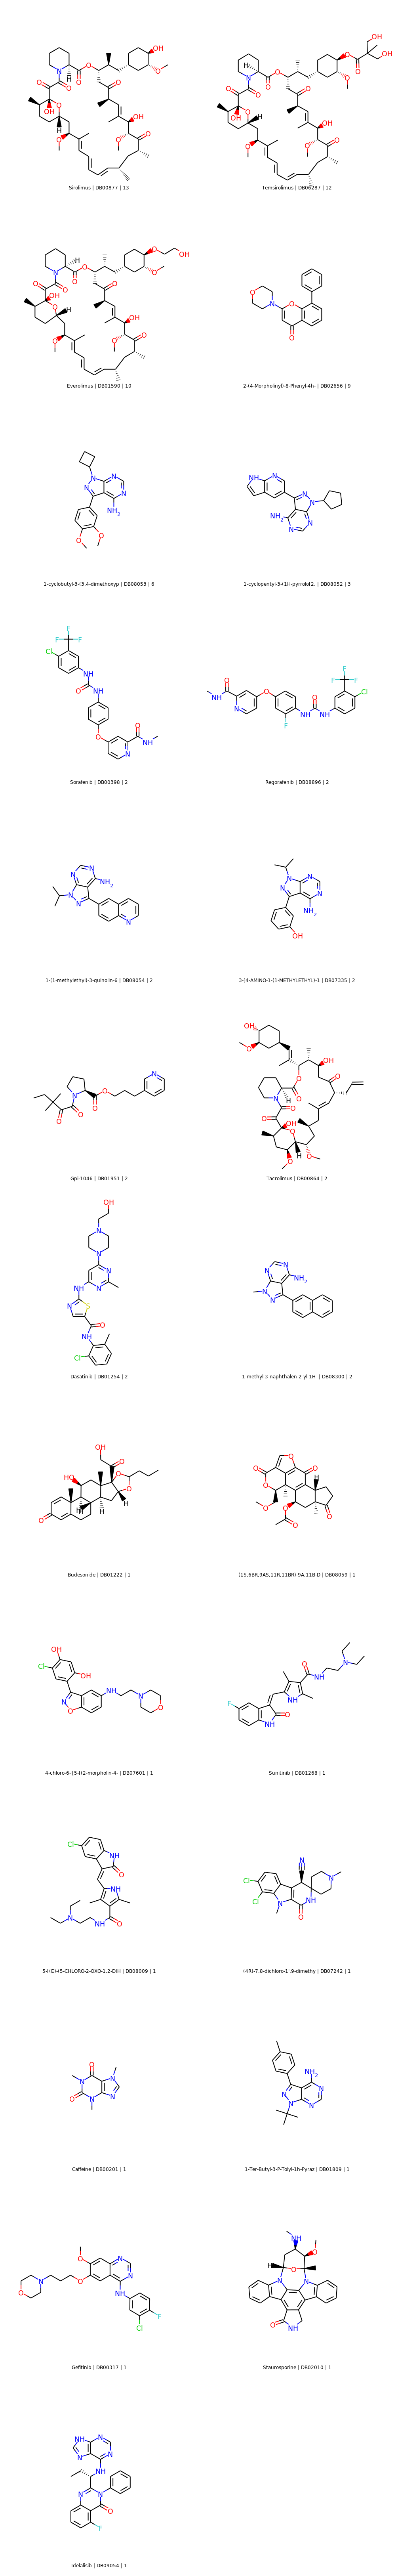

In [26]:
hit_mols = [drugs[i] for i in ordered_drugs_hitcounts]
Draw.MolsToGridImage(hit_mols, molsPerRow=2, subImgSize=(500,500),
                     legends=["{} | {} | {}".format(drugs[i].GetProp('GENERIC_NAME')[:30], # just cut off too long IUPAC stuff
                                                    drugs[i].GetProp('DRUGBANK_ID'),
                                                    drugs_hitcounts[i])
                              for i in ordered_drugs_hitcounts])

When queried for known mtor ligands using ECFP4-1024, the most frequently hit substances in the DrugBank database are Sirolimus, Temsirolimus and Everolimus with 13, 12 and 10 independent hits respectively. As stated before, those are actual mtor inhibitors, already used as drugs mostly for treating certain types of cancer.

The fourth structure hit by 9 query structures is an experimental specific inhibitor of phosphatidylinositol 3-kinase, with no apparent relatin with mtor. However, if some new proposed mtor inhibitors were too similar to drugs already noted as active on some other receptor, this might be something to investigate and consider (following the [structure-activity relationship](https://en.wikipedia.org/wiki/Structure%E2%80%93activity_relationship) rationale that similar chemical structures tend to have similar biological activity). Lack of specificity usually means side effects, something not wanted in drugs.

The cyclobutyl-containing molecule hit by 6 known mtor ligands seems to be some experimental thing targeting the [Proto-oncogene tyrosine-protein kinase Src](https://www.uniprot.org/uniprot/P12931). From a cursory look, this does not seem relevant, but again, it might be of some concern regarding possible side-effects. Same goes for the cyclopentyl-containing structure with four N-containing heterocycles hit by 3 known mtor ligands, for the quinolin-containing structure hit by 2 known mtor ligands (DB08054), for the pyrimidin-based structure also hit by 2 mtor ligands (DB08054).

The Sorafenib, Regorafenib and Dasatinib, hit by 2 known mtor ligands each, are kinase inhibitors also developed to treat certain types of cancer. Same goes for the Sunitinib, Gefitinib, Staurosporine and Idelalisib, each hit by a single known mtor ligand.

The Gpi-1046 hit by 2 known mtor ligands seems to be an outlier in both form and function. It is an experimental substance that somehow affects the Peptidyl-prolyl cis-trans isomerase FKBP1A, that in turn keeps in an inactive conformation TGFBR1, the TGF-beta type I serine/threonine kinase receptor, preventing TGF-beta receptor activation in absence of ligand. In other words, it modulates an isomerase that keeps TGF-beta receptor from misfiring. And no, I have no idea how that works :) The same isomerase is also targeted by the Tacrolimus hit by 2 known mtor ligands, which is an already approved drug for immunosuppression, namely after transplantations.

From the glancing matches hit only by a single of the known mtor ligands, there is Budesonide, a classic steroid core inhibitor of the glucocorticoid receptor, i.e. an anti-inflammatory drug.

The prize for the strangest hit goes to Caffeine, a strong student agonist :)

How about the DrugBank hits from your ligand set? What are the most hit substances? What do they do? Any strange/interesting/concerning hits?

# Diversity picking

Finding molecules that are structurally similar to our query is very useful, and indeed very often used, but it is not the only way to practically utilize the concept of structural similarity. Sometimes, the problem is very different. Often, there is a scenario where we have a large set of candidate structures, and limited time/resources/money/facilities to model/prepare/buy/test them. A computationally expensive model that can realistically process only a fraction of all your virtual compounds. A limited budget to buy substances. A grumpy and already overworked synthetic chemist. You get the idea :)

In those cases, you want to prioritize those structures of your set that have the potential to be most useful. This is usually done by using faster, less resource-intensive computational approaches. However, other things being equal, you also want to preserve the chemical diversity in your set of candidate structures. Testing 1000th variant of the same basic structure can be a waste of time in early stages of screening, chemists will do plenty of that in later stages of lead development, for the very best candidates.

In screening, it is often advantageous to sample a large set of structures in a way that covers as much of the set's chemical diversity in as few chemical structures as possible. Structural diversity is often defined an inverse of their structural similarity. Let's implement such an inverse of Tanimoto similarity, a "structural distance" of sorts:

In [27]:
def distance_function(index1, index2, *args, fingerprints=mtor_ligands_ecfp,
                      metric=DataStructs.TanimotoSimilarity):
    return 1 - DataStructs.FingerprintSimilarity(fingerprints[index1],
                                                 fingerprints[index2],
                                                 metric=metric)

Using this distance function, we can pick structures from our set so that we pick the first structure at random, the second structure as the one most distant from the first, the third structure would be the one most distant from the previous two, the fourth one the most distant from the previous three, etc. etc., until we have our diverse representative subset of chosen size. However, this distance recomputing can be quite expensive, especially for larger substance set. For few thousand structures maybe, but try a billion and despair. There are however some implementations that employ heuristics to make this selection process much faster. They are not guaranteed to provide absolutely optimal coverage, but their near-optimal solutions are perfectly fine in practice and much faster to compute. RDKit implements such pickers, most notably the MaxMin picker [described nicely here](https://rdkit.blogspot.com/2017/11/revisting-maxminpicker.html). Let's use it on our ligand set, and grab about 1%-sized diverse subset based on distance between their ECFP vectors:

In [28]:
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker
picker = MaxMinPicker()
picked = list(picker.LazyPick(distance_function, len(mtor_ligands), 45))
picked

[2742,
 179,
 3138,
 3382,
 4059,
 20,
 1383,
 632,
 2158,
 253,
 475,
 3407,
 2215,
 2595,
 4223,
 217,
 3479,
 489,
 2318,
 184,
 787,
 1134,
 2372,
 17,
 1219,
 4013,
 1141,
 3917,
 4158,
 1218,
 4040,
 925,
 2535,
 1055,
 2807,
 1976,
 4577,
 2217,
 1738,
 3082,
 1397,
 1183,
 4185,
 4509,
 409]

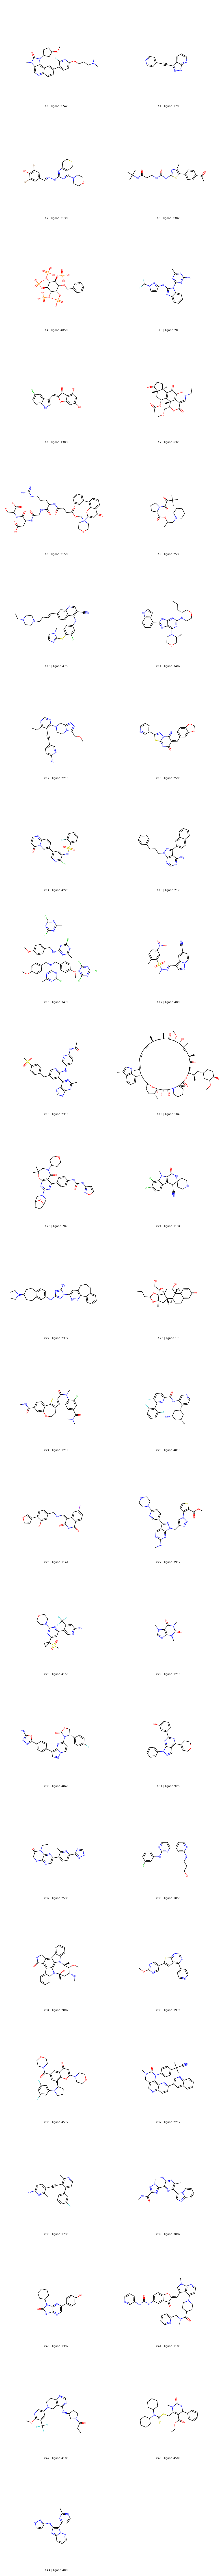

In [29]:
Draw.MolsToGridImage([mtor_ligands[i] for i in picked], molsPerRow=2, subImgSize=(500,500),
                     legends=["#{} | ligand {}".format(i, hit) for i, hit in enumerate(picked)])

That looks quite diverse :) A structure of 5 6-membered rings connected with linkers, followed by structure with more varied rings that are mostly cojoined, followed by a complete mess of chlorinated ring molecules, followed by some steroid, then some polycyclic mess with an N-containing four-membered ring connected to another heteroatom ring with a spiroatom, etc. This demonstrates the picker's ability to cover large amount of the set's chemical diversity in a relatively small amount of structures.

If you find yourself with limited resources to process all the compounds in your set, or if you just want a good test subset of your main course, some form of diversity picking is definitely a thing to consider.

# What to do:
 - Familiarize yourself with similarity between feature vectors (mainly Tanimoto), though you probably know it already :)
 - Implement for yourself a function that measures Tanimoto similarity between two binary vectors, and try it out.
 - Do a similarity search of your ligands within the DrugBank database using using hashed fingerprints (ECFP). Are any of your ligands significantly structurally similar to any DrugBank compounds? How many?
 - Do you think that some substances similar to your known ligands were already considered or even applied for therapeutic purposes?
 - Implement for yourself a function that measures Tanimoto dissimilarity for the purposes of diversity picking.
 - Perform diversity picking on your ligand set, i.e. use the diversity picker to select a small representative subset of mutually dissimilar structures that cover as much of the chemical diversity of your ligand set as possible. Pick at least 20 representative structures, or around 1% of your ligand set size, whichever one is greater. Visualize the picked structures.
 - Does each next picked structure differ considerably from the previously picked ones, or is the subset limited to only few structural motifs? What would the latter mean?